# CryptoProphet
## Notebook's Goal
> Train and assess results of XGBoost Regression model over only Text Embeddings

In [1]:
# imports custom packages
from src.paths import LOCAL_RAW_DATA_PATH, LOCAL_PROCESSED_DATA_PATH, LOCAL_MODELS_PATH
from src.visualization.stats import plot_stats_regressor

# imports official packages
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from tqdm._tqdm_notebook import tqdm_notebook
from collections import OrderedDict
from xgboost import plot_importance
import matplotlib.pyplot as plt 
from scipy.stats import skew
import missingno as msno
import pandas as pd
import xgboost
import pickle

tqdm_notebook.pandas()

seed = 42

# imports data
df_path = LOCAL_PROCESSED_DATA_PATH / 'pretrain_dataset_20211013.pkl'
df = pd.read_pickle(df_path)
tgt_vars = [c for c in df.columns if '_change_' in str(c)]

# drops unused columns
drop_cols = ['created_at', 'created_at_trunc_h', 'id_str',
             'full_text', 'user_screen_name',
             'ma_120_periods', 'ma_720_periods'] + tgt_vars
X_cols = [c for c in df.columns if c not in drop_cols]

c:\users\muril\.virtualenvs\crypto-prophet-ckjwbuny\lib\site-packages\ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  import sys


In [10]:
# prints top 30 features (without text embeddings)
df.columns[:30]

Index([                  'created_at',           'created_at_trunc_h',
                             'id_str',                    'full_text',
                      'retweet_count',               'favorite_count',
                   'user_screen_name',                    'user_feat',
                                'BTC',                         'DOGE',
                                'ETH',                          'LTC',
                               'USDT',                          'ADA',
                             'volume',                        'close',
                     'ma_120_periods',               'ma_720_periods',
         'close_change_1periods_perc',   'close_change_2periods_perc',
         'close_change_6periods_perc',  'close_change_12periods_perc',
        'close_change_24periods_perc',  'close_change_48periods_perc',
       'close_change_168periods_perc', 'close_change_360periods_perc',
       'close_change_750periods_perc',                              0,
      

In [12]:
# shows top values
df.head()

,created_at,created_at_trunc_h,id_str,full_text,retweet_count,favorite_count,user_screen_name,user_feat,BTC,DOGE,...,758,759,760,761,762,763,764,765,766,767
67894,2019-06-24 00:48:17,2019-06-24 00:00:00,1142957583340380160,@roysebag @mikejcasey https://t.co/HAdE9hivHb,1.0,5.0,BarrySilbert,3,0,0,...,0.211892,0.090323,-0.033169,-0.074099,0.049208,0.008833,0.092621,-0.013973,-0.091649,-0.009876
109535,2019-06-24 01:45:59,2019-06-24 01:00:00,1142972105182601216,@SoroushG_ @hasufl Perhaps expanding to non-ec...,0.0,4.0,FEhrsam,14,0,0,...,0.159535,0.046459,-0.129009,-0.051730,0.037167,0.012580,0.112651,-0.005474,0.065391,0.004129
89071,2019-06-24 03:39:16,2019-06-24 03:00:00,1143000611329388544,@NPO_SPS_2013 @Emurgo_Japan 投稿ありがとうございました！是非、 ...,1.0,30.0,Cardano,5,0,0,...,-0.211426,-0.008754,0.002088,-0.107030,0.079004,0.251885,0.013369,-0.043283,0.211008,0.042472
89070,2019-06-24 04:04:05,2019-06-24 04:00:00,1143006856761266176,"On June 22, #CardanoFoundation attended the fi...",50.0,235.0,Cardano,5,0,0,...,-0.063294,0.127559,0.099624,-0.001857,-0.068960,0.112617,-0.000934,0.009449,0.031449,0.055679
89069,2019-06-24 04:23:13,2019-06-24 04:00:00,1143011672560427008,ご注意ください：ダイダロスのサポートをすると言ってデータを抜き取り#ADA を盗まれるという...,42.0,123.0,Cardano,5,0,0,...,-0.196956,-0.077403,0.033810,-0.181430,0.158272,0.118863,-0.029405,-0.137520,0.256907,-0.011696


In [2]:
# defines X and y variables
X = df[X_cols]
y = df['close_change_2periods_perc']

In [3]:
# sanity check on null values
X.isna().sum().sum(), y.isna().sum()

(0, 0)

In [4]:
# splits dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed)

In [5]:
# sanity check on resulting shapes
print(X_train.shape,  X_test.shape)
print(y_train.shape,  y_test.shape)
df.shape[0] == X_train.shape[0] + X_test.shape[0] 

(73656, 779) (18415, 779)
(73656,) (18415,)


True

In [7]:
# inits and fits model
xgboost.set_config(**{'use_rmm': False, 'verbosity': 1})

model = xgboost.XGBRegressor(**{
    'colsample_bytree': 0.8,
    'gamma': 0,
    'learning_rate': 0.01,
    'max_depth': 5,
    'min_child_weight': 1.5,
    'n_estimators': 1200,
    'reg_alpha': 0.75,
    'reg_lambda': 0.45,
    'seed': seed,
    'subsample': 0.9
}) 

model.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=5,
             min_child_weight=1.5, missing=nan, monotone_constraints='()',
             n_estimators=1200, n_jobs=8, num_parallel_tree=1, random_state=42,
             reg_alpha=0.75, reg_lambda=0.45, scale_pos_weight=1, seed=42,
             subsample=0.9, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [10]:
# exports model
with open(LOCAL_MODELS_PATH / 'xgboost_20211013.pkl', mode='wb') as fp:
    pickle.dump(model, fp)

In [ ]:
# loads user label encoder
with open(LOCAL_MODELS_PATH / 'user_label_encoder.pkl', mode='rb') as fp:
    user_le = pickle.load(fp)

training - R^2 score:  0.19543645428602952


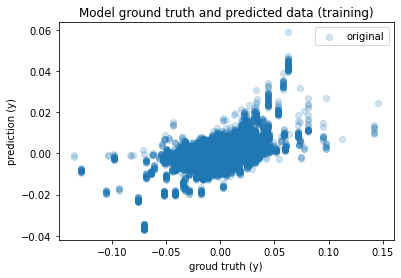

testing - R^2 score:  0.16185177953939467


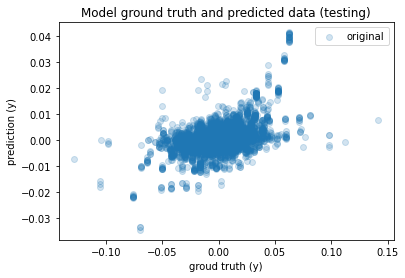

In [17]:
# plots results
plot_stats_regressor(model, X_train, y_train, test_name='training')
plot_stats_regressor(model, X_test, y_test, test_name='testing')

Bitboy_Crypto - 3242 tweets
Bitboy_Crypto - full data - R^2 score:  0.13732417311445677


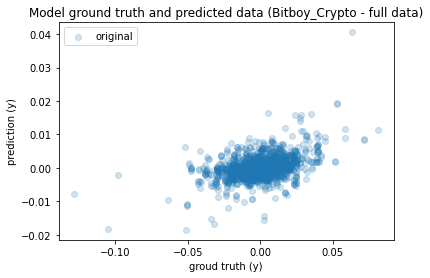

Bitboy_Crypto - train data - R^2 score:  0.1242343442397067


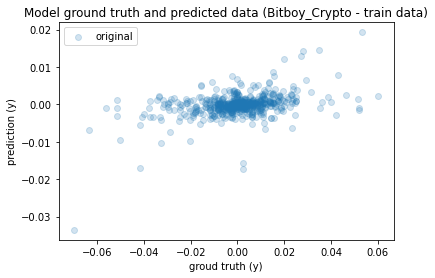

TheCryptoDog - 3245 tweets
TheCryptoDog - full data - R^2 score:  0.2531801176420341


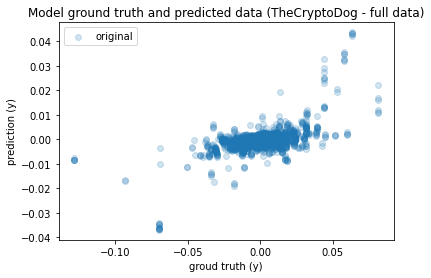

TheCryptoDog - train data - R^2 score:  0.214343585232609


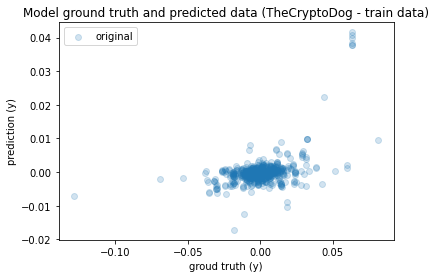

davidgokhshtein - 3450 tweets
davidgokhshtein - full data - R^2 score:  0.2176752572284505


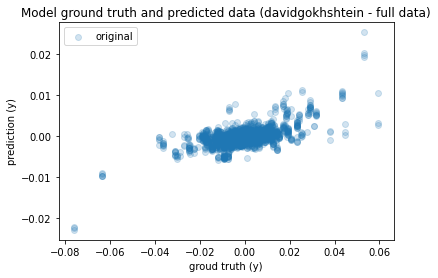

davidgokhshtein - train data - R^2 score:  0.18771374483123482


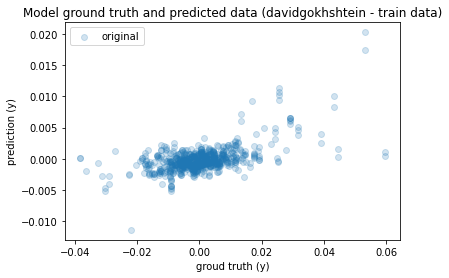

justinsuntron - 3406 tweets
justinsuntron - full data - R^2 score:  0.12207472392534413


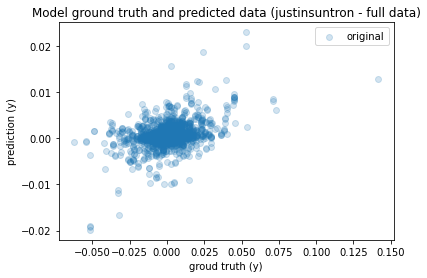

justinsuntron - train data - R^2 score:  0.04167814273850501


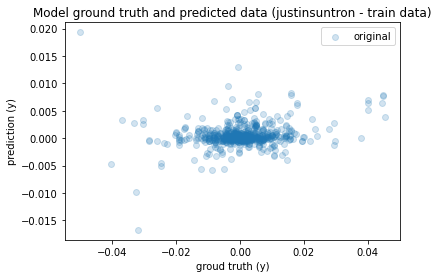

CryptoCobain - 3445 tweets
CryptoCobain - full data - R^2 score:  0.22989509066063984


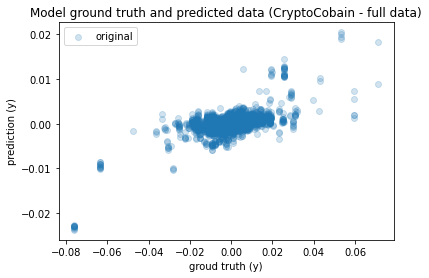

CryptoCobain - train data - R^2 score:  0.2096254854089431


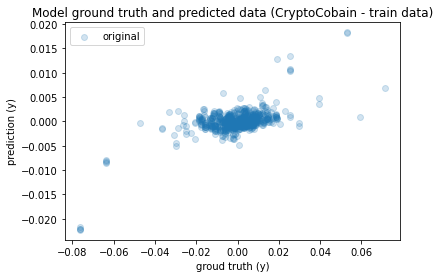

CryptoWendyO - 3436 tweets
CryptoWendyO - full data - R^2 score:  0.17936548298318367


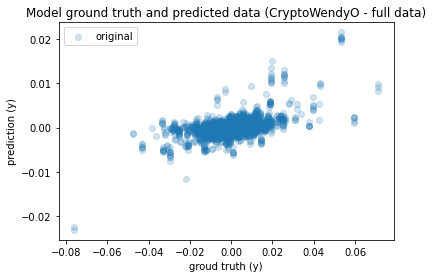

CryptoWendyO - train data - R^2 score:  0.1373908301261616


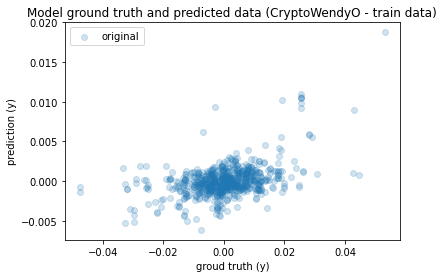

LayahHeilpern - 3246 tweets
LayahHeilpern - full data - R^2 score:  0.29768978776220056


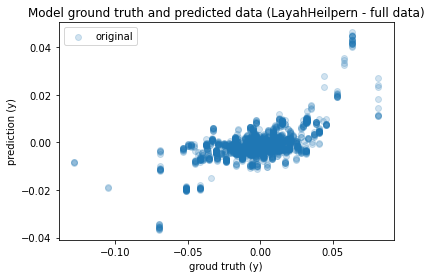

LayahHeilpern - train data - R^2 score:  0.24850832689031677


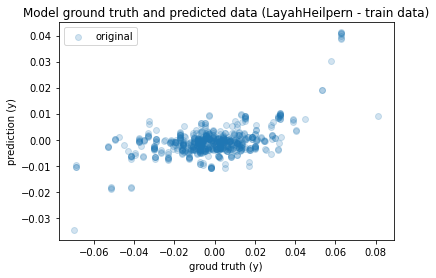

IvanOnTech - 3410 tweets
IvanOnTech - full data - R^2 score:  0.15195747081016941


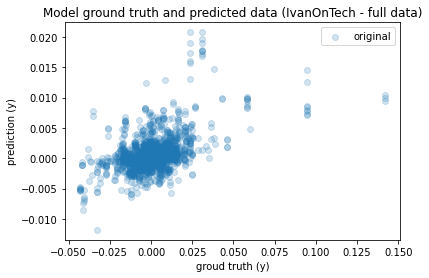

IvanOnTech - train data - R^2 score:  0.050916134366707944


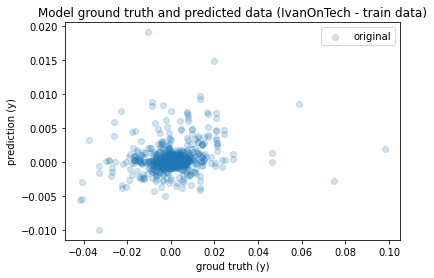

coinbureau - 2419 tweets
coinbureau - full data - R^2 score:  0.11354608556414092


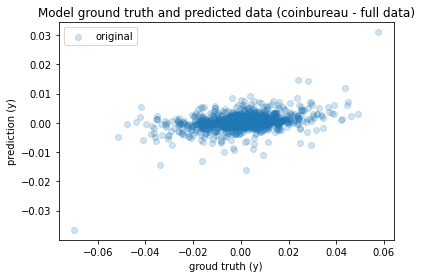

coinbureau - train data - R^2 score:  0.05292500909382758


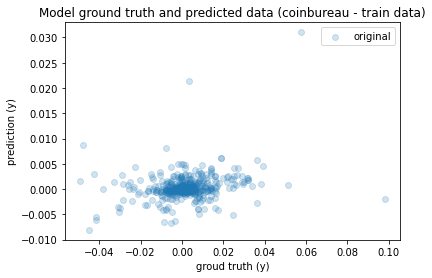

BarrySilbert - 1491 tweets
BarrySilbert - full data - R^2 score:  0.1335694578527713


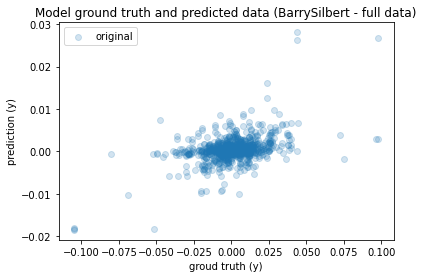

BarrySilbert - train data - R^2 score:  0.04528588027219149


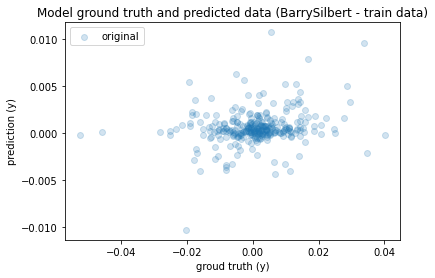

Cardano - 2150 tweets
Cardano - full data - R^2 score:  0.06611863665110473


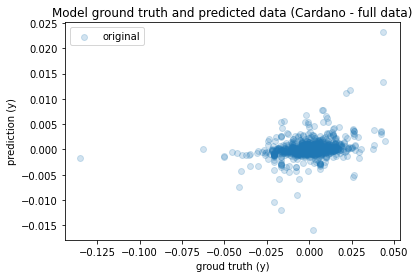

Cardano - train data - R^2 score:  0.04251883306009141


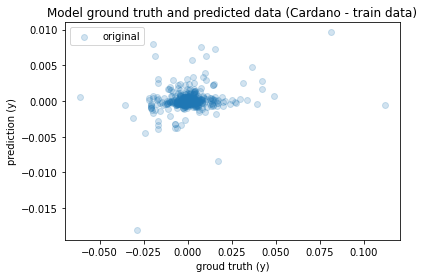

100trillionUSD - 2285 tweets
100trillionUSD - full data - R^2 score:  0.11229727661536515


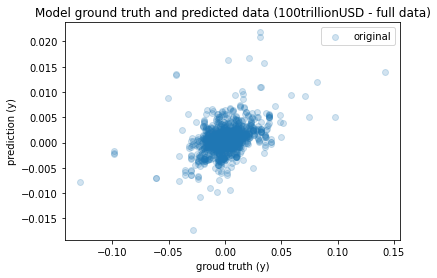

100trillionUSD - train data - R^2 score:  0.10393496462554097


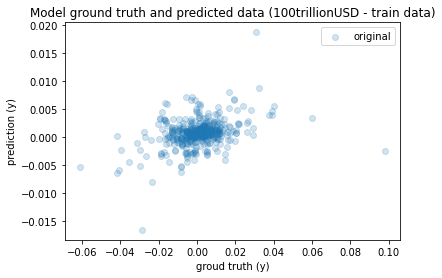

girlgone_crypto - 3448 tweets
girlgone_crypto - full data - R^2 score:  0.16111730191736717


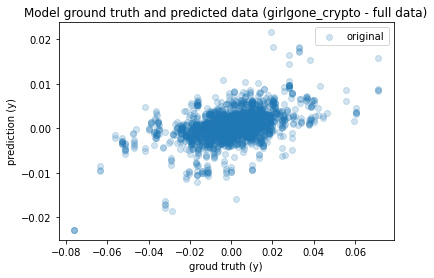

girlgone_crypto - train data - R^2 score:  0.13165488089213517


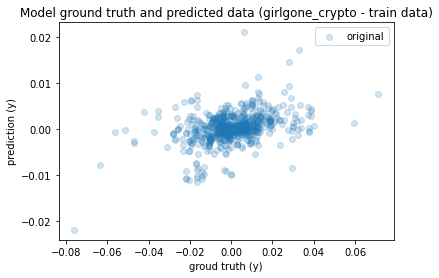

brian_armstrong - 332 tweets
brian_armstrong - full data - R^2 score:  0.08558918867544618


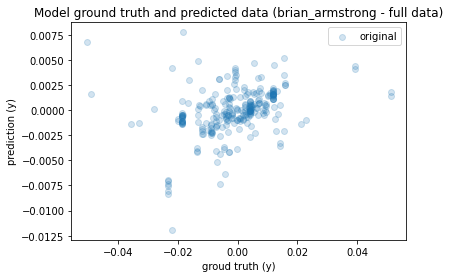

brian_armstrong - train data - R^2 score:  0.02080950265681991


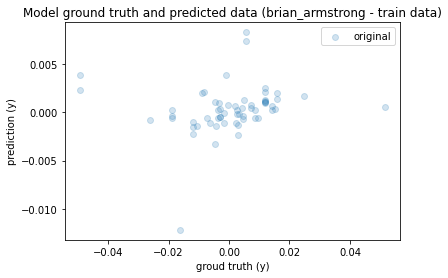

officialmcafee - 3235 tweets
officialmcafee - full data - R^2 score:  0.08335981456356867


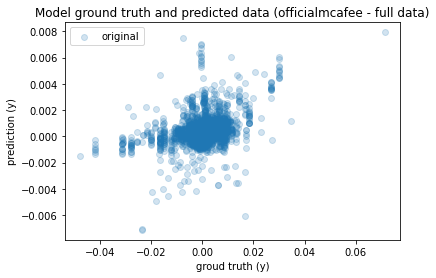

officialmcafee - train data - R^2 score:  0.0629088551430913


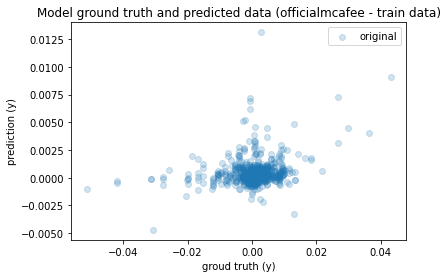

VitalikButerin - 3191 tweets
VitalikButerin - full data - R^2 score:  0.040382936107654754


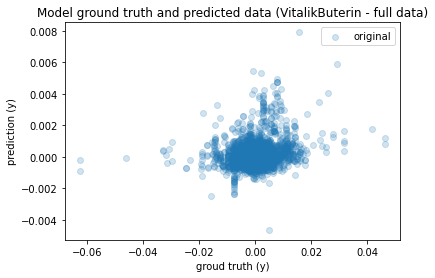

VitalikButerin - train data - R^2 score:  -0.0007893111741210657


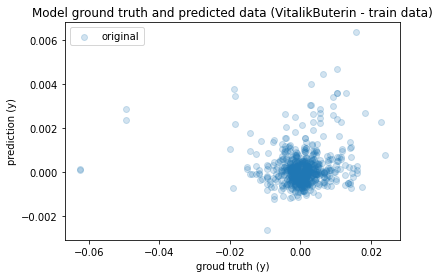

elonmusk - 3237 tweets
elonmusk - full data - R^2 score:  0.09118966469253786


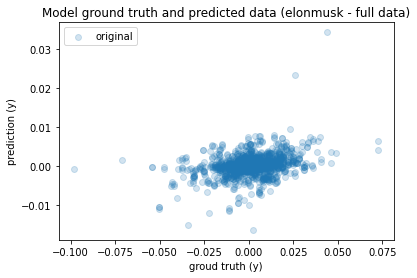

elonmusk - train data - R^2 score:  0.05926656630510874


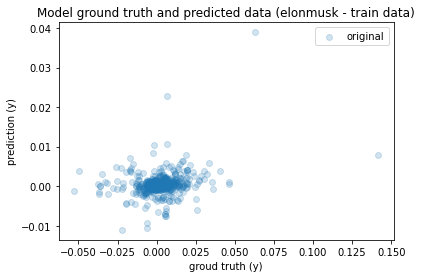

danheld - 3241 tweets
danheld - full data - R^2 score:  0.26215938746811707


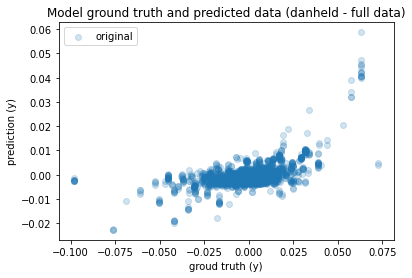

danheld - train data - R^2 score:  0.24577274918918424


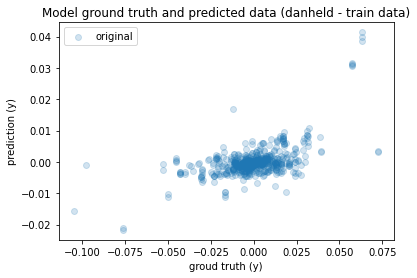

APompliano - 3449 tweets
APompliano - full data - R^2 score:  0.1728493396409707


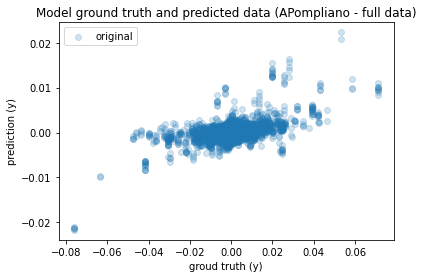

APompliano - train data - R^2 score:  0.13951102075257737


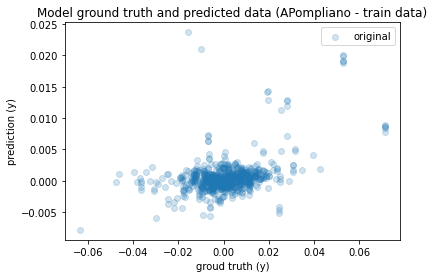

mysticaloaks - 3450 tweets
mysticaloaks - full data - R^2 score:  0.1869387630953201


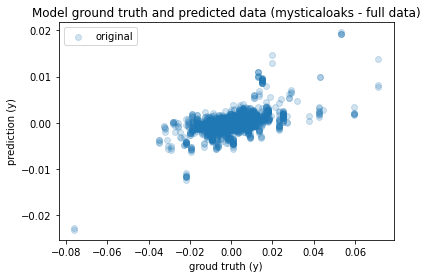

mysticaloaks - train data - R^2 score:  0.14752030561587526


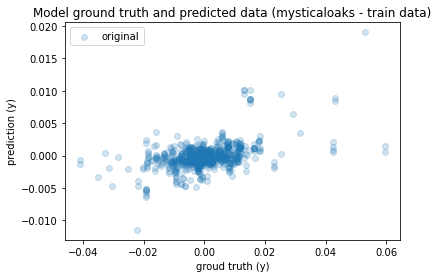

ToneVays - 3438 tweets
ToneVays - full data - R^2 score:  0.14513418651080767


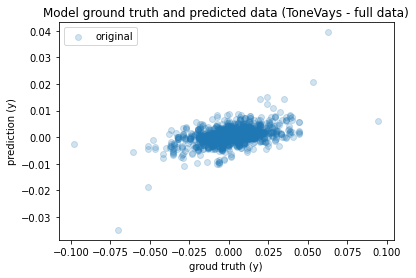

ToneVays - train data - R^2 score:  0.06119202178827676


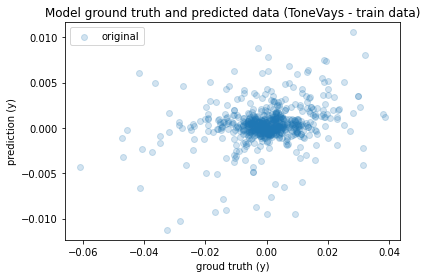

rogerkver - 575 tweets
rogerkver - full data - R^2 score:  0.07474702931774324


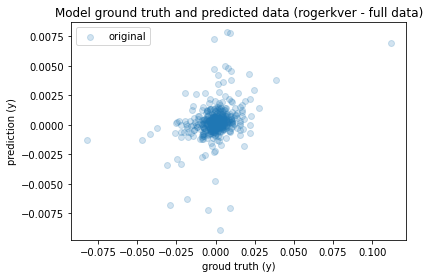

rogerkver - train data - R^2 score:  -0.006727774736639658


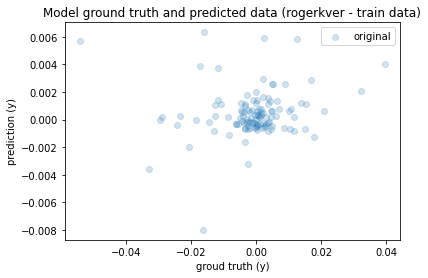

CryptoEuclid - 3341 tweets
CryptoEuclid - full data - R^2 score:  0.15640522817294045


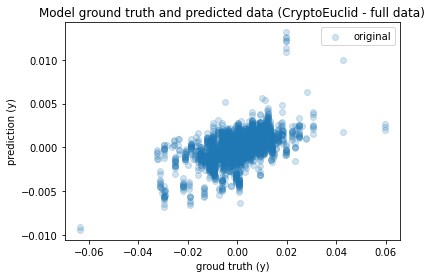

CryptoEuclid - train data - R^2 score:  0.11039230928704324


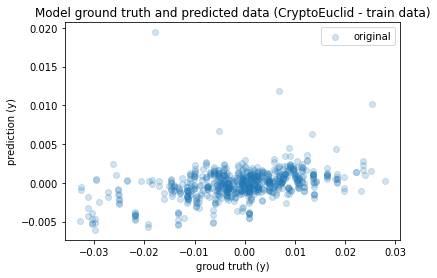

ErikVoorhees - 3447 tweets
ErikVoorhees - full data - R^2 score:  0.2391467990502847


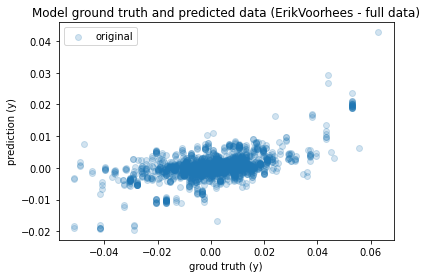

ErikVoorhees - train data - R^2 score:  0.19479863871288772


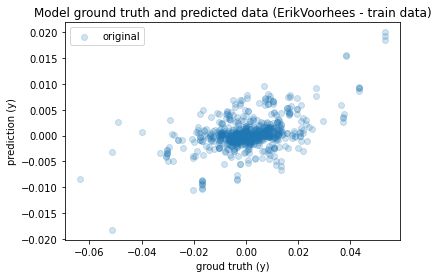

aantonop - 3316 tweets
aantonop - full data - R^2 score:  0.10616966916069004


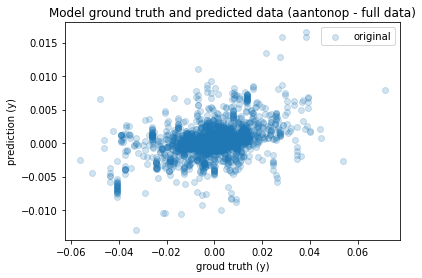

aantonop - train data - R^2 score:  0.028823929263590675


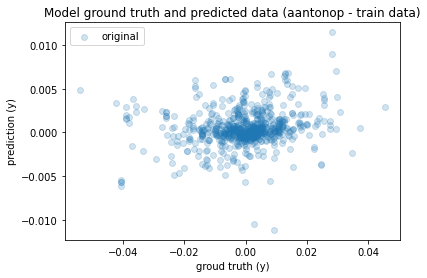

intocryptoverse - 1003 tweets
intocryptoverse - full data - R^2 score:  0.2385221028437966


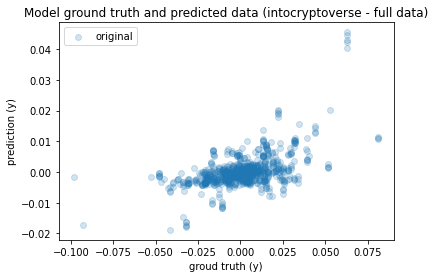

intocryptoverse - train data - R^2 score:  0.21152725728470922


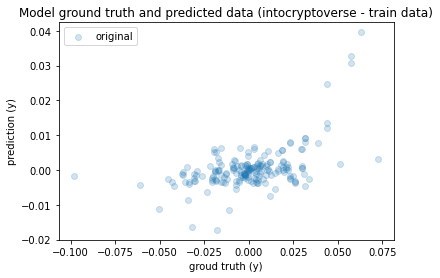

StackerSatoshi - 1444 tweets
StackerSatoshi - full data - R^2 score:  0.1245024375624958


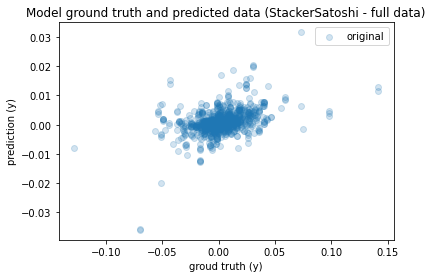

StackerSatoshi - train data - R^2 score:  0.06776762427951843


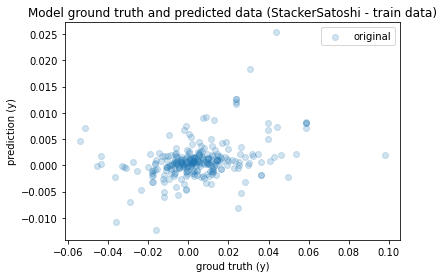

TheMoonCarl - 1184 tweets
TheMoonCarl - full data - R^2 score:  0.20731980574285735


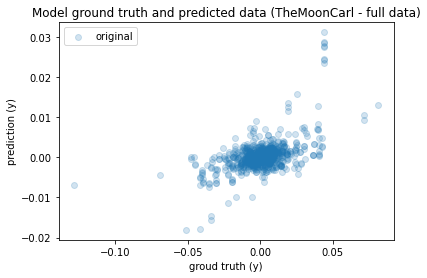

TheMoonCarl - train data - R^2 score:  0.2693728862006578


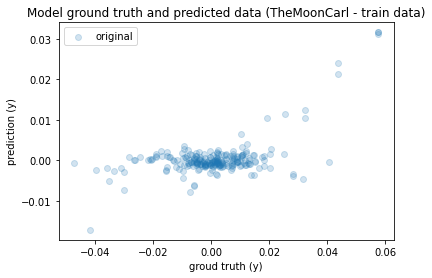

TyDanielSmith - 2367 tweets
TyDanielSmith - full data - R^2 score:  0.0892796200354109


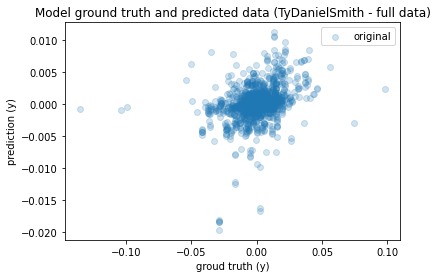

TyDanielSmith - train data - R^2 score:  0.10298087277216816


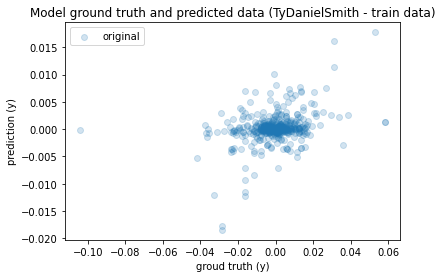

SatoshiLite - 2120 tweets
SatoshiLite - full data - R^2 score:  0.0905588862713631


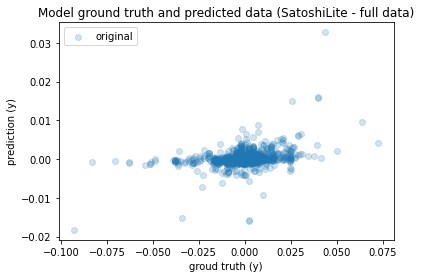

SatoshiLite - train data - R^2 score:  0.12031120038787146


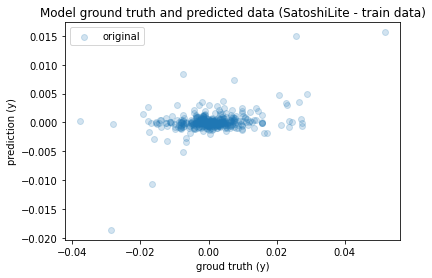

KennethBosak - 3450 tweets
KennethBosak - full data - R^2 score:  0.1618558892811245


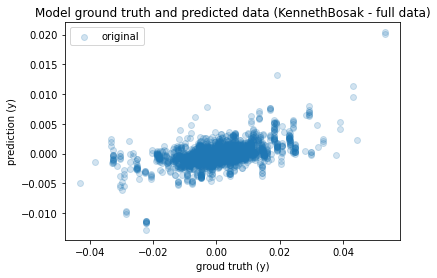

KennethBosak - train data - R^2 score:  0.1858522141455774


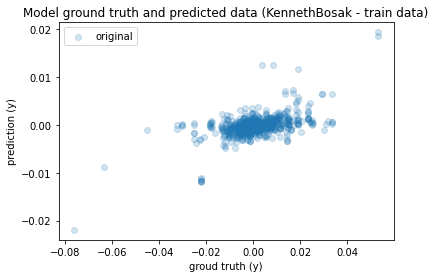

PeterMcCormack - 3240 tweets
PeterMcCormack - full data - R^2 score:  0.37315895759099593


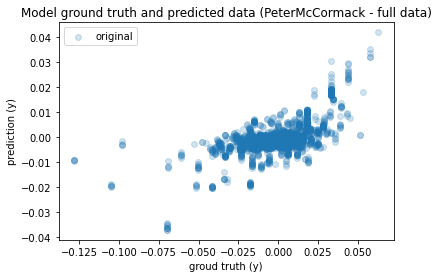

PeterMcCormack - train data - R^2 score:  0.3529704534573006


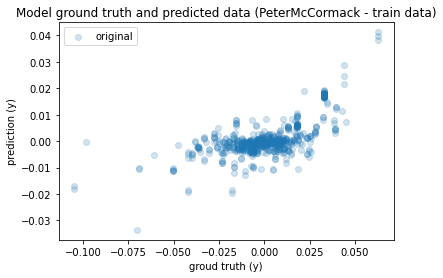

TimDraper - 572 tweets
TimDraper - full data - R^2 score:  0.10426743113261994


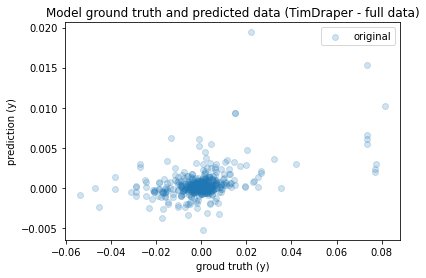

TimDraper - train data - R^2 score:  0.040953931809335375


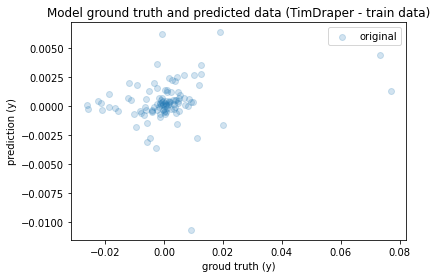

ethereum - 917 tweets
ethereum - full data - R^2 score:  0.06059456809172037


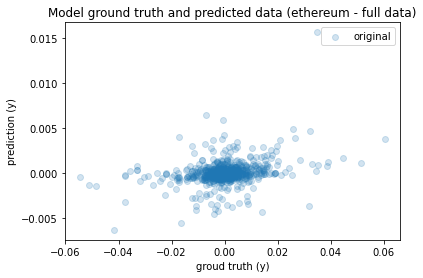

ethereum - train data - R^2 score:  0.0694884682140926


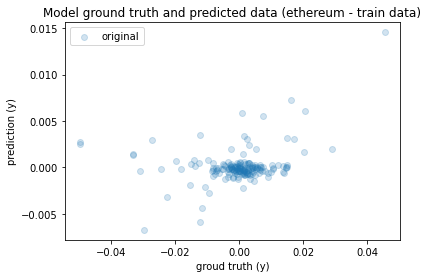

Coinbound_io - 882 tweets
Coinbound_io - full data - R^2 score:  0.13967979419258247


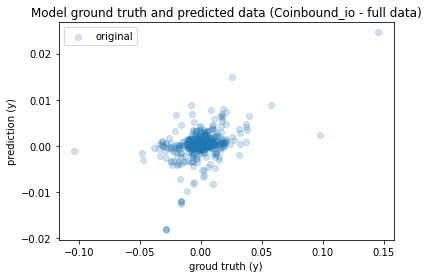

Coinbound_io - train data - R^2 score:  -0.056896274702608274


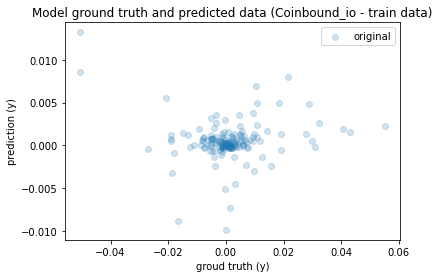

bhorowitz - 573 tweets
bhorowitz - full data - R^2 score:  0.2016837097030254


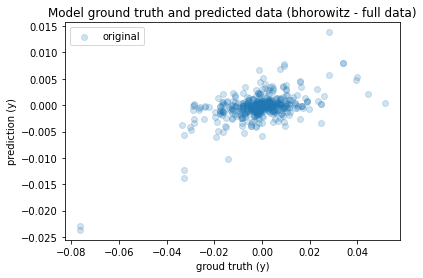

bhorowitz - train data - R^2 score:  0.19807475458734136


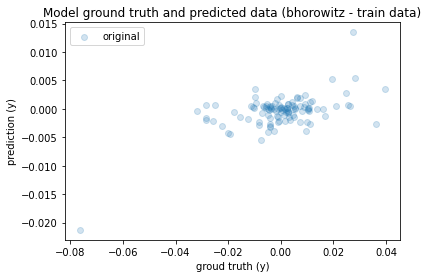

AltcoinDailyio - 650 tweets
AltcoinDailyio - full data - R^2 score:  0.11593372912102429


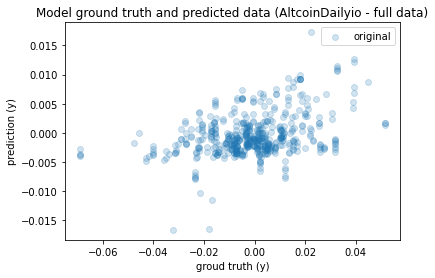

AltcoinDailyio - train data - R^2 score:  0.03447827140446302


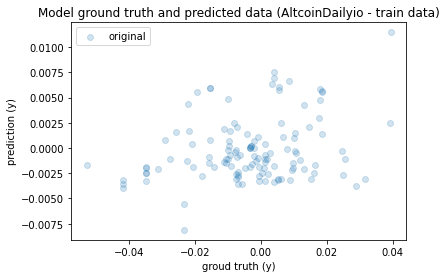

FEhrsam - 337 tweets
FEhrsam - full data - R^2 score:  0.21081575186821233


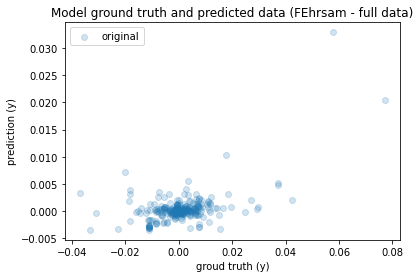

FEhrsam - train data - R^2 score:  -0.04958614056342081


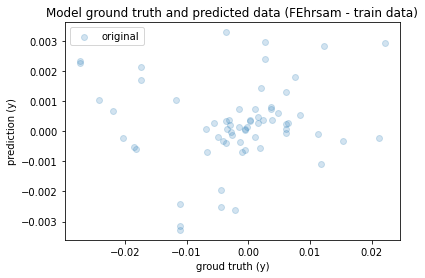

EuclidAndOaks - 317 tweets
EuclidAndOaks - full data - R^2 score:  0.03163160027869638


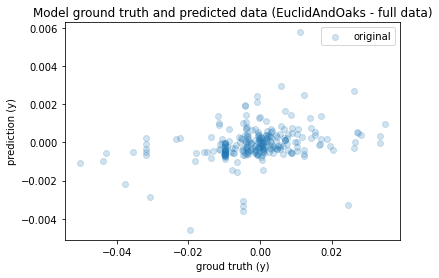

EuclidAndOaks - train data - R^2 score:  0.0759748847731595


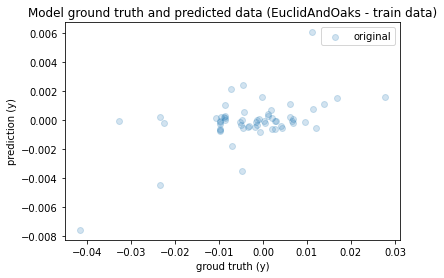

Cryptosrus - 73 tweets
Cryptosrus - full data - R^2 score:  0.11032371328254964


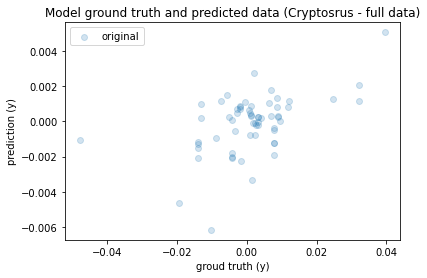

Cryptosrus - train data - R^2 score:  0.23620820951863508


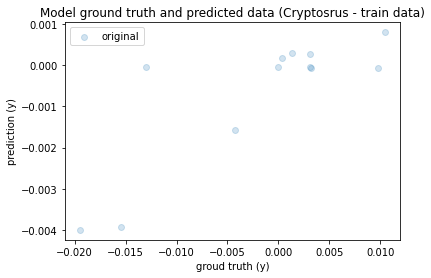

CryptoBrekkie - 3 tweets
CryptoBrekkie - full data - R^2 score:  -0.729268252199238


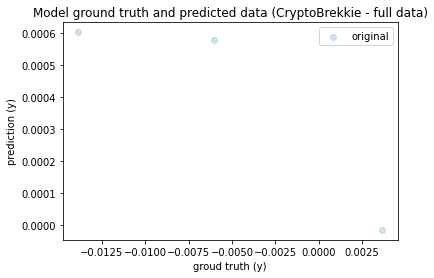

error Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
Maxwell_Maher - 11 tweets
Maxwell_Maher - full data - R^2 score:  -0.7193330923660823


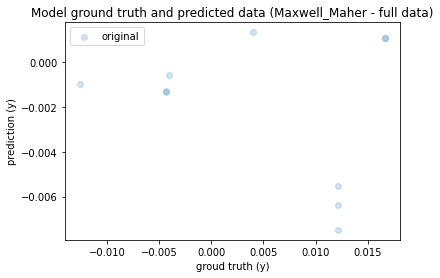

Maxwell_Maher - train data - R^2 score:  nan


c:\users\muril\.virtualenvs\crypto-prophet-ckjwbuny\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


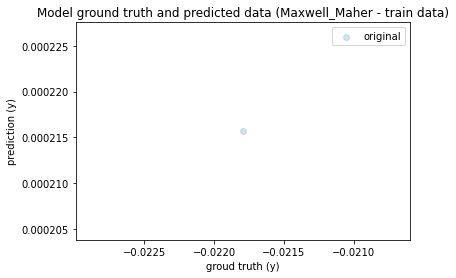

StackingUSD - 3 tweets
StackingUSD - full data - R^2 score:  0.08791834392498943


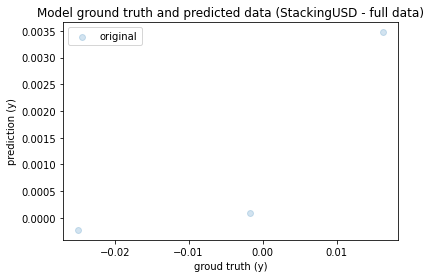

error Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.


In [24]:
# plots results broken down per influencer
for u in X_train.user_feat.unique():
    mask = X_train.user_feat == u
    mask_test = X_test.user_feat == u
    user_screen_name = user_le.inverse_transform([u])[0]
    print(f"{user_screen_name} - {mask.sum() + mask_test.sum()} tweets")

    try:
        plot_stats_regressor(model, X_train[mask], y_train[mask], test_name=f"{user_screen_name} - full data")
        plot_stats_regressor(model, X_test[mask_test], y_test[mask_test], test_name=f"{user_screen_name} - train data")
    except Exception as e:
        print(f'error {e}')
        
    print(20*'=')

# Conclusion
> Model overall contains too much noise, but some influencer show promissing results
>
> (eg. PeterMcCormack with R² score of   ~0.37).